# **Predicting Customer Credit Card Churn**
### Stephanie Smith

## Motivation & Objectives
This project analyzes customer data from an undisclosed bank that is facing challenges in retaining its credit card users. By utilizing customer data, including customer demographic and spending attributes, three predictive models were developed to identify and understand customer churn. The results of this analysis address the following questions:<br>
1. Which customer attributes are most strongly correlated with churn?<br>
2. Which model best predicts customer churn?<br>
3. Which model best fits this specific business context?


Dataset: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

In [17]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, randint
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [134]:
# load data
df = pd.read_csv('BankChurners.csv')

In [136]:
# Remove the last two columns as suggested by the dataset documentation, they are not needed for training, testing or any analysis

df = df.iloc[:, :-2]

print(df.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44 

## **Exploratory Data Analysis**

In [139]:
# Examine number of rows and columns
rows, columns = df.shape
print("There are", rows, "records in the dataset, and", columns, "columns")

There are 10127 records in the dataset, and 21 columns


In [141]:
# Confirm there are no duplicates by examing the CLIENTNUM variable
duplicates_clientnum = df['CLIENTNUM'].duplicated()
print(duplicates_clientnum.value_counts())

CLIENTNUM
False    10127
Name: count, dtype: int64


In [143]:
# Examine dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [145]:
# Examine summary statistics for integer and float variables
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In examining the minimum and maximum values for each numerical variable, all ranges seem appropriate, there are no obvious errors.

In [148]:
# Examine categorical variables

categorical_var = df[['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']]

for var in categorical_var:
    print(f'{var}: {categorical_var[var].unique()}','\n',)

print('Attrition Flag:', df['Attrition_Flag'].unique())


Gender: ['M' 'F'] 

Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate'] 

Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced'] 

Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown'] 

Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum'] 

Attrition Flag: ['Existing Customer' 'Attrited Customer']


In [150]:
#Examine value counts of categorical variables
print('Frequency Tables of Categorical Variables')
for var in categorical_var:
    print(categorical_var[var].value_counts(),'\n')
    
print(df['Attrition_Flag'].value_counts(),'\n')


#Examine proportions of categorical variables
print('Proportion Tables of Categorical Variables')
for var in categorical_var:
    print(categorical_var[var].value_counts(normalize=True),'\n')
    
print(df['Attrition_Flag'].value_counts(normalize=True))

Frequency Tables of Categorical Variables
Gender
F    5358
M    4769
Name: count, dtype: int64 

Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64 

Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64 

Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64 

Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64 

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64 

Proportion Tables of Categorical Variables
Gender
F    0.529081
M    0.470919
Name: proportion, dtype: float64 

Education_Level
Graduate         0.308877
High School      0.198776
Unknown          0.149995


The proportion of unkown marital status is 7%, the proportion of unkown education level is 15%, the proportion of unkown income is 11%. We will impute the unkown with the mode of each variable.

In [153]:
#Check how many customers put unkown for all three catogories
unknown_all = df[(df['Education_Level'] == 'Unknown') & 
                  (df['Income_Category'] == 'Unknown') & 
                  (df['Marital_Status'] == 'Unknown')]

print(len(unknown_all))

7


In [155]:
#Check how many customers put unkown for all three catogories
unknown_rows = df[(df['Education_Level'] == 'Unknown') |
                  (df['Income_Category'] == 'Unknown') | 
                  (df['Marital_Status'] == 'Unknown')]

print(len(unknown_rows))

3046


In [157]:
# Examine Numerical Variables

num_var = df[['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]

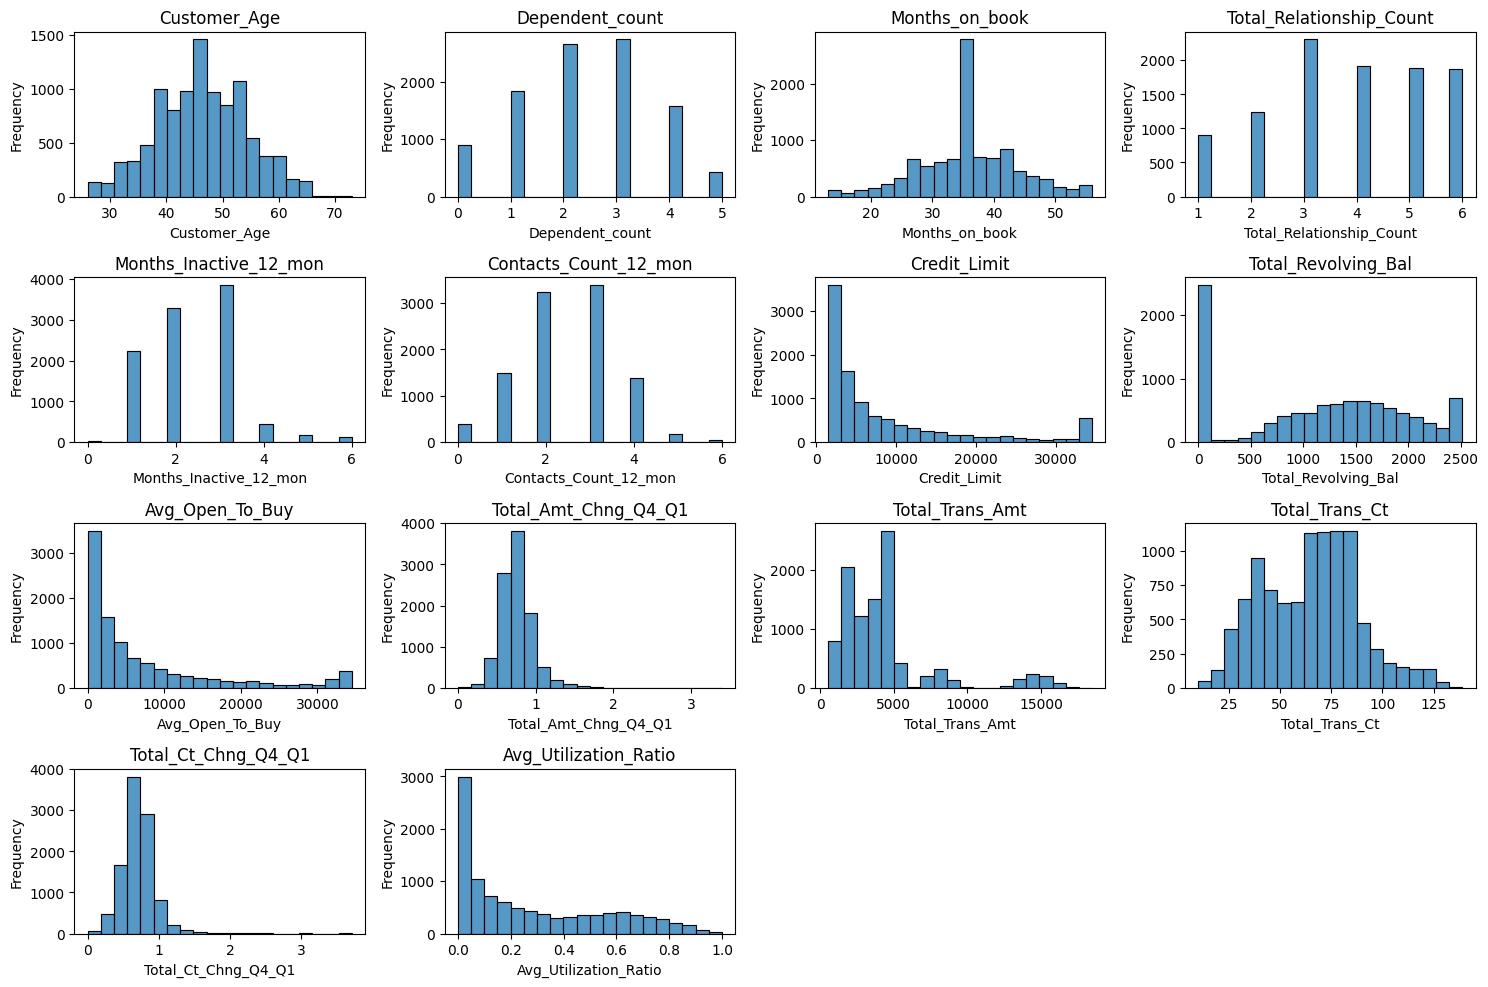

In [159]:
# Histogrm to examin distributions
plt.figure(figsize=(15, 12))
for i, var in enumerate(num_var): 
    plt.subplot(5, 4, i + 1) 
    sns.histplot(df[var], kde=False, bins=20)
    plt.title(f'{var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    
plt.tight_layout()  
plt.show()


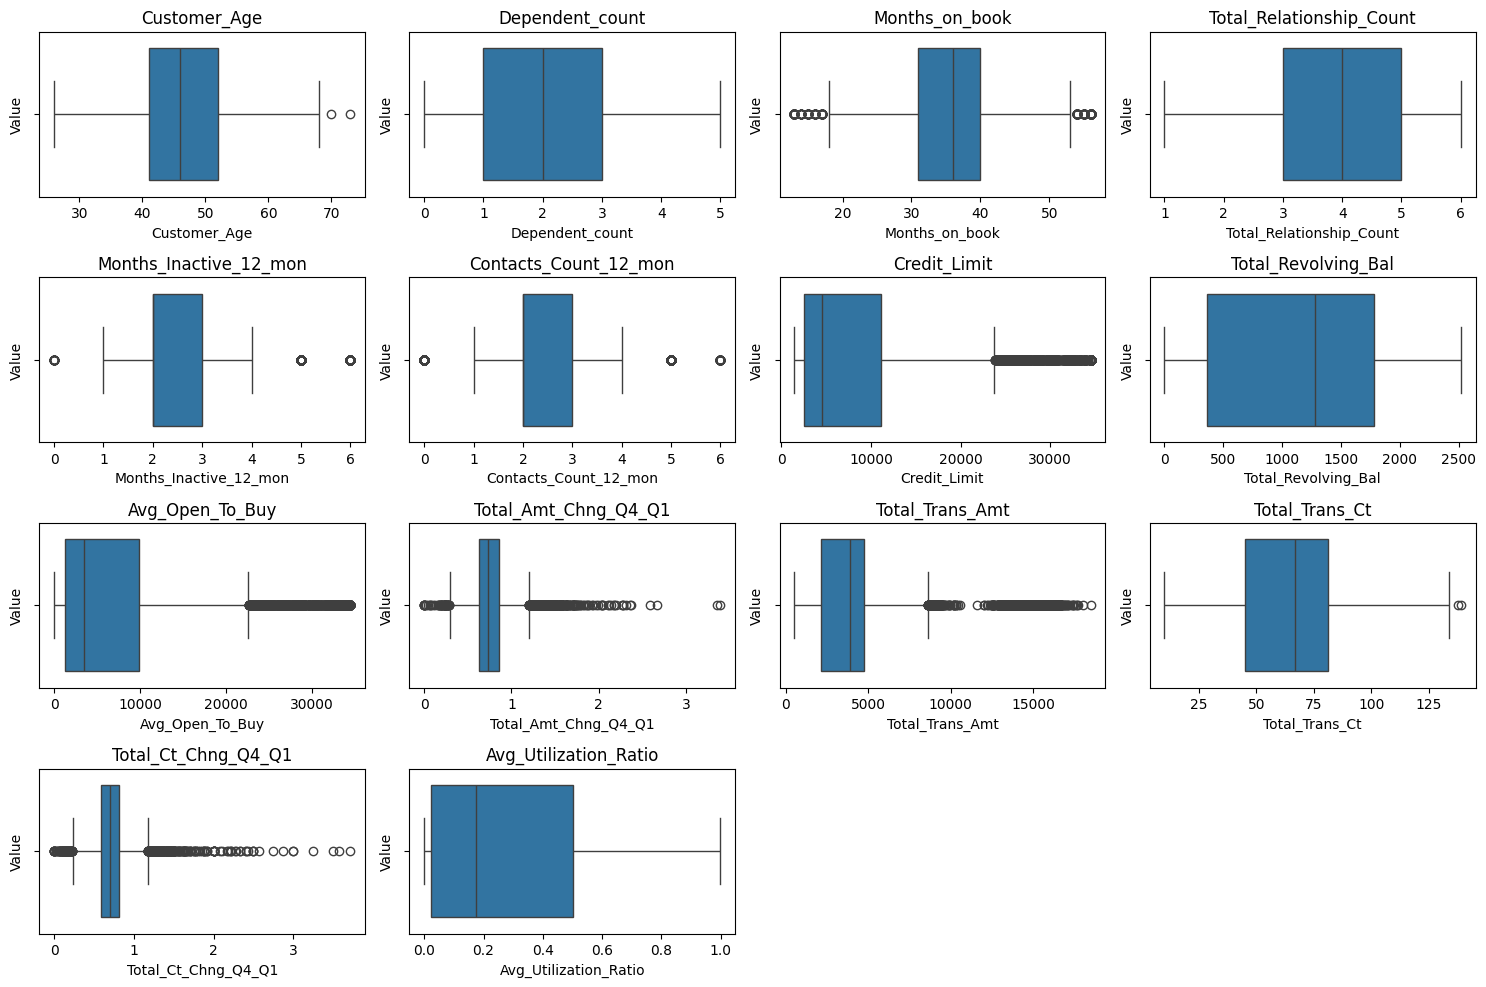

In [160]:
# Boxplot to examine outliers
plt.figure(figsize=(15, 12))
for i, var in enumerate(num_var): 
    plt.subplot(5, 4, i + 1) 
    sns.boxplot(x=df[var])
    plt.title(f'{var}')
    plt.xlabel(var)
    plt.ylabel('Value')
    
plt.tight_layout()  
plt.show()


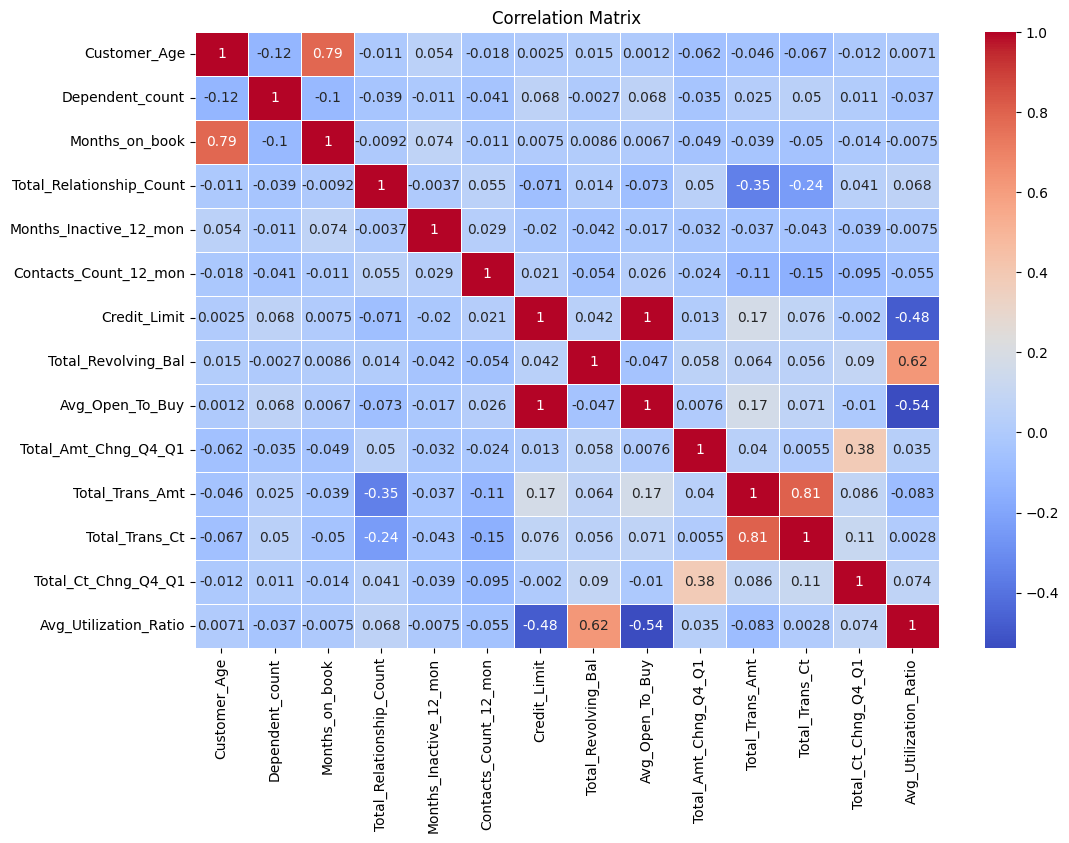

In [161]:
# Correlation matrix of numerical values
correlation_mat=num_var.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals several pairs of predictor variables with high correlations, which indicates potential redundancy. To improve model performance and avoid multicollinearity, we will consider dropping redundant variables during feature selection. Customer Age and Months on Book are highly correlated, with a correlation coefficient of 0.79. Average Open to Buy and Credit Limit have a perfectly linear relationship with a correlation coefficient of 1.0. Average Utilization Ratio and Total Revolving Balance have a moderately high correlation with a coefficient of 0.62. Total Transaction Count and Total Transaction Amount have a high correlation of 0.81.

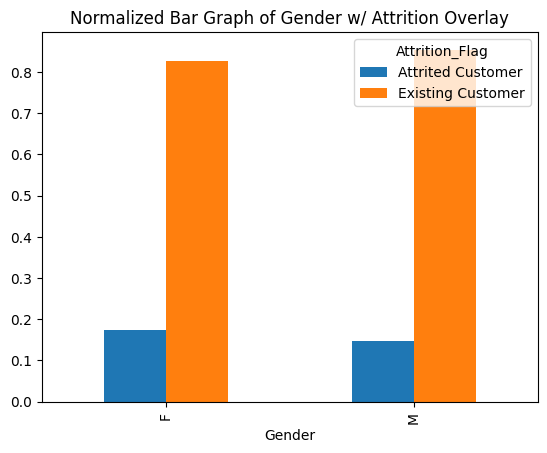

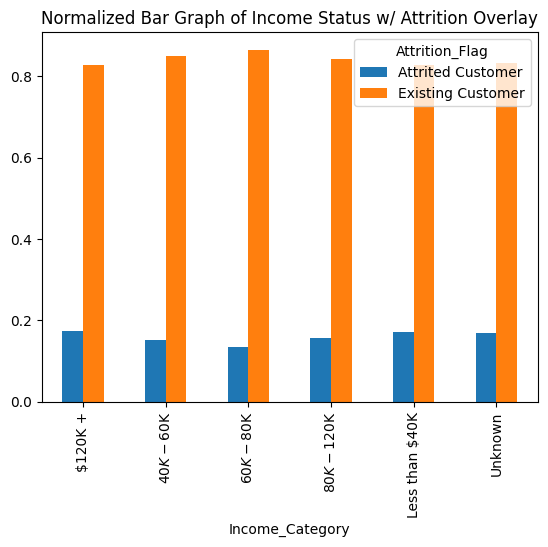

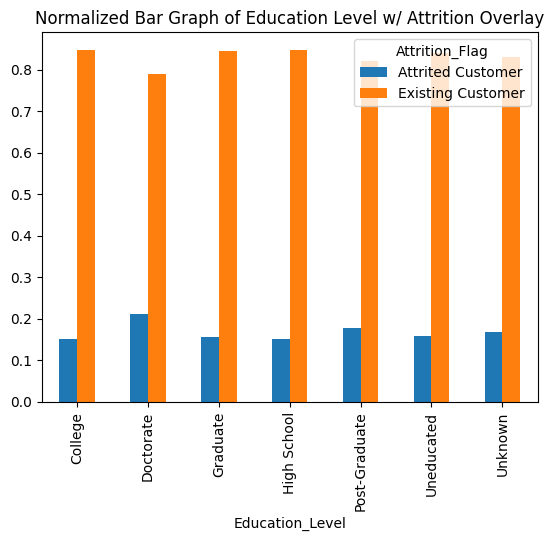

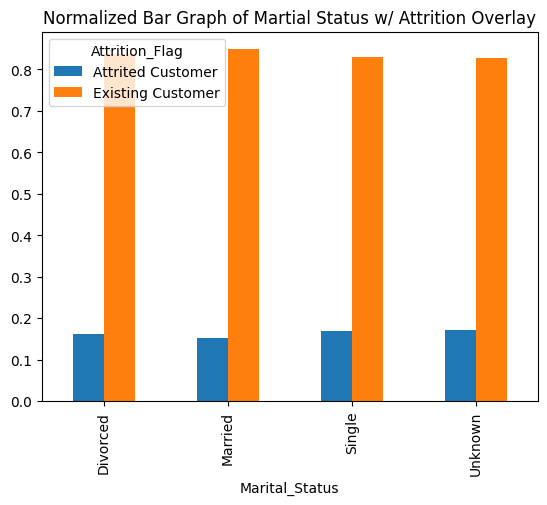

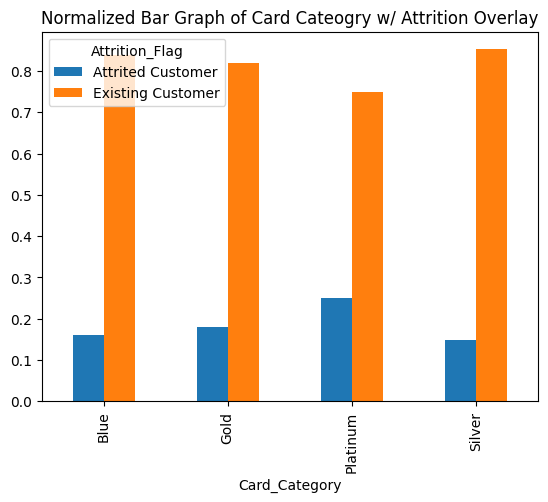

In [163]:
# Examine normalized bar graphs of categorical variables with overlay of attrition flag

#Gender
crosstab_gender = pd.crosstab(df['Gender'], df['Attrition_Flag'])
crosstab_norm_gender = crosstab_gender.div(crosstab_gender.sum(axis=1), axis = 0)
crosstab_norm_gender.plot(kind='bar')
plt.title('Normalized Bar Graph of Gender w/ Attrition Overlay')
plt.show()

#Income
crosstab_income = pd.crosstab(df['Income_Category'], df['Attrition_Flag'])
crosstab_norm_income = crosstab_income.div(crosstab_income.sum(axis=1), axis = 0)
crosstab_norm_income.plot(kind='bar')
plt.title('Normalized Bar Graph of Income Status w/ Attrition Overlay')
plt.show()


#Education
crosstab_education = pd.crosstab(df['Education_Level'], df['Attrition_Flag'])
crosstab_norm_education = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_norm_education.plot(kind='bar')
plt.title('Normalized Bar Graph of Education Level w/ Attrition Overlay')
plt.show()


#Marital
crosstab_marital = pd.crosstab(df['Marital_Status'], df['Attrition_Flag'])
crosstab_norm_marital = crosstab_marital.div(crosstab_marital.sum(axis=1), axis = 0)
crosstab_norm_marital.plot(kind='bar')
plt.title('Normalized Bar Graph of Martial Status w/ Attrition Overlay')
plt.show()

#Card
crosstab_card = pd.crosstab(df['Card_Category'], df['Attrition_Flag'])
crosstab_norm_card = crosstab_card.div(crosstab_card.sum(axis=1), axis = 0)
crosstab_norm_card.plot(kind='bar')
plt.title('Normalized Bar Graph of Card Cateogry w/ Attrition Overlay')
plt.show()

In [165]:
#Perform chi square tests

for var in categorical_var:
    print(f"\n Chi-Square Test: Attrition vs. {var}")
    
    ct = pd.crosstab(df['Attrition_Flag'], df[var])
    
    chi2, p, dof, expected = chi2_contingency(ct)

    print("Chi-Square:", round(chi2, 4))
    print("p-value:", round(p, 4))

#Examine education and income as well
ct = pd.crosstab(df['Education_Level'], df['Income_Category'])
    
chi2, p, dof, expected = chi2_contingency(ct)
print(f"\n Chi-Square Test: Education vs. Income")
print("Chi-Square:", round(chi2, 4))
print("p-value:", round(p, 4))



 Chi-Square Test: Attrition vs. Gender
Chi-Square: 13.8656
p-value: 0.0002

 Chi-Square Test: Attrition vs. Education_Level
Chi-Square: 12.5112
p-value: 0.0515

 Chi-Square Test: Attrition vs. Marital_Status
Chi-Square: 6.0561
p-value: 0.1089

 Chi-Square Test: Attrition vs. Income_Category
Chi-Square: 12.8323
p-value: 0.025

 Chi-Square Test: Attrition vs. Card_Category
Chi-Square: 2.2342
p-value: 0.5252

 Chi-Square Test: Education vs. Income
Chi-Square: 45.2537
p-value: 0.0366


The Chi-square test results indicate the following correlations between Attrition and other cateogrical variables: There is a statistically significant correlation between Attrition and Gender, with a p-value of 0.0002. There is a statistically significant correlation between Attrition and Income Category, with a p-value of 0.0126. Marital Status is not significantly correlated with Attrition, and Card Category is not significantly correlated with Attrition (p-value > 0.10). Education Level is just on the cusp of being significant, with a p-value of 0.0464.

## **Data Preprocessing**

In [170]:
#Changing Attrition Flag to 0 and 1 
#0 is exisiting customers and should have 8500 counts
#1 is attrited customers and should have 1627 counts  

df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0 ,'Attrited Customer': 1})

In [174]:
print(df['Attrition_Flag'].value_counts())

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64


In [176]:
#Check Attrition column 
df['Attrition_Flag'].head()

0    0
1    0
2    0
3    0
4    0
Name: Attrition_Flag, dtype: int64

In [178]:
# Create dummy variables for all the categorical variables 
df_dummy = list(df.select_dtypes('object')) #identify object-type columns 


for i in df_dummy:
    dummy_col=pd.get_dummies(df[i], drop_first=True, prefix = i, dtype =int) #create dummy variable
    df= pd.concat([df,dummy_col], axis=1) #concatenate dummy columns to dataframe
    df.drop(columns = i, inplace = True) #drop original categorical column because we dont want 'object' type in model

In [180]:
df.info() #now dont have any 'Object' category 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       10127 non-null  int64  
 1   Attrition_Flag                  10127 non-null  int64  
 2   Customer_Age                    10127 non-null  int64  
 3   Dependent_count                 10127 non-null  int64  
 4   Months_on_book                  10127 non-null  int64  
 5   Total_Relationship_Count        10127 non-null  int64  
 6   Months_Inactive_12_mon          10127 non-null  int64  
 7   Contacts_Count_12_mon           10127 non-null  int64  
 8   Credit_Limit                    10127 non-null  float64
 9   Total_Revolving_Bal             10127 non-null  int64  
 10  Avg_Open_To_Buy                 10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1            10127 non-null  float64
 12  Total_Trans_Amt                 

We split the data at this point, we only want to make certain preprocessing changes on the training dataset

In [183]:
# Split data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['Attrition_Flag'])

In [185]:
# Make a copy of the testing and training dataset
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

In [187]:
# Transform variables that are highly skewed using log transformation

df_train_processed['Credit_Limit_Log'] = np.log(df_train_processed['Credit_Limit'] + 1)  
df_test_processed['Credit_Limit_Log'] = np.log(df_test_processed['Credit_Limit'] + 1)  

df_train_processed['Total_Trans_Amt_Log'] = np.log(df_train_processed['Total_Trans_Amt'] + 1)
df_test_processed['Total_Trans_Amt_Log'] = np.log(df_test_processed['Total_Trans_Amt'] + 1) 

df_train_processed['Total_Ct_Chng_Q4_Q1_Log'] = np.log(df_train_processed['Total_Ct_Chng_Q4_Q1'] + 1)  
df_test_processed['Total_Ct_Chng_Q4_Q1_Log'] = np.log(df_test_processed['Total_Ct_Chng_Q4_Q1'] + 1)  

df_train_processed['Total_Amt_Chng_Q4_Q1'] = np.log(df_train_processed['Total_Amt_Chng_Q4_Q1'] + 1)  
df_test_processed['Total_Amt_Chng_Q4_Q1'] = np.log(df_test_processed['Total_Amt_Chng_Q4_Q1'] + 1)  

In [189]:
# Standardize continous variables

scaler = StandardScaler()

# Only standardize continous variables
cols_to_standardize = ['Customer_Age', 'Credit_Limit', 'Total_Trans_Amt', 
                       'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal']


df_train_processed[cols_to_standardize] = scaler.fit_transform(df_train_processed[cols_to_standardize])

# Standardize the test data using the same scaler from training data
df_test_processed[cols_to_standardize] = scaler.transform(df_test_processed[cols_to_standardize])



In [191]:
# Check
print(df_train_processed['Customer_Age'].head())
print(df_test_processed['Customer_Age'].head())

3105    0.835722
3721   -0.286925
3389    0.461506
3552    0.461506
398     1.085199
Name: Customer_Age, dtype: float64
9760   -1.783787
7413    0.461506
6074    0.960460
3520    1.833630
6103   -0.661140
Name: Customer_Age, dtype: float64


### **Modeling Phase 1 Logistic Regression** <br> MODEL #1 Logistic Regression - Baseline

The first logistic model includes 22 predictor variables; We have exclude some of the original variables based off the correlation testing and chi square testing. We utilize SMOTE to account for the imbalance between the existing customer class and attrited customer class.

In [195]:
X_train = df_train_processed[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train = df_train_processed['Attrition_Flag']


# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Add constant
X_train_resampled = sm.add_constant(X_train_resampled)

# Fit model
logreg01 = sm.Logit(y_train_resampled, X_train_resampled).fit()

# Output the model summary
logreg01.summary2()

Optimization terminated successfully.
         Current function value: 0.366257
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                    Logit                Method:               MLE       
Dependent Variable:       Attrition_Flag       Pseudo R-squared:     0.472     
Date:                     2025-08-20 15:19     AIC:                  10006.7363
No. Observations:         13598                BIC:                  10179.6429
Df Model:                 22                   Log-Likelihood:       -4980.4   
Df Residuals:             13575                LL-Null:              -9425.4   
Converged:                1.0000               LLR p-value:          0.0000    
No. Iterations:           7.0000               Scale:                1.0000    
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                           3.8965   0.1652  23.5822 0.0000  3.5726  4.2203
Gender_M                       -1.7941   0.1019 -17.6028 0.0000 -1.9938 -1.5943
Education_Level_Doctorate      -2.4247   0.1546 -15.6830 0.0000 -2.7277 -2.1216
Education_Level_Graduate       -1.8762   0.0712 -26.3400 0.0000 -2.0158 -1.7366
Education_Level_High School    -2.0218   0.0814 -24.8278 0.0000 -2.1814 -1.8622
Education_Level_Post-Graduate  -2.2650   0.1472 -15.3889 0.0000 -2.5535 -1.9765
Education_Level_Uneducated     -2.2641   0.0942 -24.0464 0.0000 -2.4486 -2.0795
Education_Level_Unknown        -2.1076   0.0900 -23.4073 0.0000 -2.2841 -1.9312
Income_Category_$40K - $60K    -2.9340   0.1154 -25.4223 0.0000 -3.1602 -2.7078
Income_Category_$60K - $80K    -1.9201   0.1087 -17.6710 0.0000 -2.1331 -1.7071
Income_Category_$80K - $120K   -1.6053   0.1005 -15.9666 0.0000 -1.8023 -1.4082
Income_Category_Less than $40K -2.9163   0.1165 -25.0297 0.0000 -3.1447 -2.6879
Income_Category_Unknown        -3.7099   0.1396 -26.5829 0.0000 -3.9834 -3.4363
Customer_Age                   -0.0756   0.0273  -2.7668 0.0057 -0.1292 -0.0220
Credit_Limit                   -0.0631   0.0326  -1.9339 0.0531 -0.1271  0.0009
Total_Trans_Amt                -0.6535   0.0385 -16.9535 0.0000 -0.7290 -0.5779
Dependent_count                -0.0648   0.0206  -3.1457 0.0017 -0.1052 -0.0244
Total_Relationship_Count       -0.4550   0.0177 -25.7441 0.0000 -0.4896 -0.4203
Months_Inactive_12_mon          0.3382   0.0273  12.3765 0.0000  0.2846  0.3917
Contacts_Count_12_mon           0.3837   0.0251  15.2623 0.0000  0.3345  0.4330
Total_Amt_Chng_Q4_Q1            0.0067   0.0297   0.2254 0.8216 -0.0516  0.0650
Total_Ct_Chng_Q4_Q1            -0.9638   0.0358 -26.9006 0.0000 -1.0340 -0.8936
Total_Revolving_Bal            -0.6718   0.0239 -28.1162 0.0000 -0.7186 -0.6250
===============================================================================

"""

### **MODEL #2 Logistic Regression - Additional Feature Selection, remove Total_Amt_Chng**

In model 1 the variable Total_Amt_Chng_Q4_Q1 has a p-value of 0.8216, indicating it is not significant, in model 2 we drop this variable.

In [199]:
X_train = df_train_processed[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train = df_train_processed['Attrition_Flag']


# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Add constant
X_train_resampled = sm.add_constant(X_train_resampled)

# Fit model
logreg02 = sm.Logit(y_train_resampled, X_train_resampled).fit()

# Output the model summary
logreg02.summary2()

Optimization terminated successfully.
         Current function value: 0.368137
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                    Logit                Method:               MLE       
Dependent Variable:       Attrition_Flag       Pseudo R-squared:     0.469     
Date:                     2025-08-20 15:19     AIC:                  10055.8417
No. Observations:         13598                BIC:                  10221.2306
Df Model:                 21                   Log-Likelihood:       -5005.9   
Df Residuals:             13576                LL-Null:              -9425.4   
Converged:                1.0000               LLR p-value:          0.0000    
No. Iterations:           7.0000               Scale:                1.0000    
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                           3.9171   0.1655  23.6659 0.0000  3.5927  4.2415
Gender_M                       -1.7916   0.1027 -17.4407 0.0000 -1.9929 -1.5902
Education_Level_Doctorate      -2.4021   0.1521 -15.7881 0.0000 -2.7004 -2.1039
Education_Level_Graduate       -1.9194   0.0714 -26.8818 0.0000 -2.0594 -1.7795
Education_Level_High School    -2.0983   0.0821 -25.5466 0.0000 -2.2593 -1.9374
Education_Level_Post-Graduate  -2.3670   0.1498 -15.8023 0.0000 -2.6606 -2.0734
Education_Level_Uneducated     -2.2502   0.0928 -24.2513 0.0000 -2.4320 -2.0683
Education_Level_Unknown        -2.1460   0.0896 -23.9606 0.0000 -2.3216 -1.9705
Income_Category_$40K - $60K    -2.8576   0.1162 -24.5864 0.0000 -3.0854 -2.6298
Income_Category_$60K - $80K    -1.8366   0.1084 -16.9487 0.0000 -2.0490 -1.6242
Income_Category_$80K - $120K   -1.5489   0.1005 -15.4191 0.0000 -1.7458 -1.3520
Income_Category_Less than $40K -2.8420   0.1182 -24.0345 0.0000 -3.0738 -2.6102
Income_Category_Unknown        -3.6348   0.1405 -25.8721 0.0000 -3.9102 -3.3595
Customer_Age                   -0.0744   0.0272  -2.7368 0.0062 -0.1276 -0.0211
Credit_Limit                   -0.0554   0.0326  -1.6998 0.0892 -0.1192  0.0085
Total_Trans_Amt                -0.6959   0.0389 -17.9104 0.0000 -0.7721 -0.6198
Dependent_count                -0.0634   0.0205  -3.0862 0.0020 -0.1036 -0.0231
Total_Relationship_Count       -0.4662   0.0176 -26.5130 0.0000 -0.5007 -0.4317
Months_Inactive_12_mon          0.3357   0.0271  12.3762 0.0000  0.2825  0.3889
Contacts_Count_12_mon           0.3814   0.0250  15.2502 0.0000  0.3324  0.4304
Total_Ct_Chng_Q4_Q1            -0.9625   0.0341 -28.2027 0.0000 -1.0294 -0.8956
Total_Revolving_Bal            -0.6794   0.0239 -28.4558 0.0000 -0.7262 -0.6326
===============================================================================

"""

We validate the model by using the test dataset.

In [202]:
# Validate model 2
X_test = df_test_processed[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_test = df_test_processed['Attrition_Flag']

X_test = sm.add_constant(X_test)
logreg02_val = sm.Logit(y_test, X_test).fit()
logreg02_val.summary2()

Optimization terminated successfully.
         Current function value: 0.292217
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                   Logit                Method:               MLE        
Dependent Variable:      Attrition_Flag       Pseudo R-squared:     0.336      
Date:                    2025-08-20 15:19     AIC:                  1228.0632  
No. Observations:        2026                 BIC:                  1351.5672  
Df Model:                21                   Log-Likelihood:       -592.03    
Df Residuals:            2004                 LL-Null:              -892.16    
Converged:               1.0000               LLR p-value:          1.4083e-113
No. Iterations:          7.0000               Scale:                1.0000     
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                          -2.0586   0.6190  -3.3256 0.0009 -3.2718 -0.8453
Gender_M                       -0.9546   0.3133  -3.0468 0.0023 -1.5686 -0.3405
Education_Level_Doctorate       0.5635   0.4010   1.4054 0.1599 -0.2223  1.3494
Education_Level_Graduate        0.2568   0.2923   0.8784 0.3797 -0.3161  0.8296
Education_Level_High School     0.2859   0.3137   0.9113 0.3621 -0.3289  0.9007
Education_Level_Post-Graduate   0.4599   0.4179   1.1003 0.2712 -0.3593  1.2790
Education_Level_Uneducated      0.4470   0.3237   1.3806 0.1674 -0.1876  1.0815
Education_Level_Unknown         0.4425   0.3208   1.3794 0.1678 -0.1862  1.0711
Income_Category_$40K - $60K    -1.3022   0.4096  -3.1791 0.0015 -2.1050 -0.4994
Income_Category_$60K - $80K    -0.9301   0.3489  -2.6658 0.0077 -1.6139 -0.2463
Income_Category_$80K - $120K   -0.3444   0.3225  -1.0678 0.2856 -0.9764  0.2877
Income_Category_Less than $40K -1.3184   0.4356  -3.0267 0.0025 -2.1721 -0.4647
Income_Category_Unknown        -1.0281   0.4572  -2.2487 0.0245 -1.9241 -0.1320
Customer_Age                   -0.0822   0.0780  -1.0542 0.2918 -0.2350  0.0706
Credit_Limit                   -0.1208   0.0914  -1.3222 0.1861 -0.2999  0.0583
Total_Trans_Amt                -0.5009   0.1142  -4.3864 0.0000 -0.7247 -0.2771
Dependent_count                 0.0812   0.0602   1.3487 0.1774 -0.0368  0.1991
Total_Relationship_Count       -0.4901   0.0550  -8.9071 0.0000 -0.5979 -0.3822
Months_Inactive_12_mon          0.4578   0.0734   6.2326 0.0000  0.3138  0.6017
Contacts_Count_12_mon           0.5026   0.0725   6.9326 0.0000  0.3605  0.6447
Total_Ct_Chng_Q4_Q1            -1.2738   0.1119 -11.3831 0.0000 -1.4931 -1.0545
Total_Revolving_Bal            -0.6966   0.0776  -8.9776 0.0000 -0.8487 -0.5445
===============================================================================

"""

There are instabilities with the coefficients of the education level and income category variables. As well as a lot of variables that were significant when using the training data but not when using the testing data. This may be an indication that the model is instable, or overfitting. We examine the confusion matrix to see how the model is performing.

In [205]:
# Examine evaulation metrics for Model 2
y_pred = logreg02.predict(X_test)

# impose threshold threshold of 0.5 to classify predictions
y_pred_class = (y_pred > 0.5).astype(int)

# Print confusion matrix
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

Accuracy: 0.8252714708785784
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      1701
           1       0.47      0.62      0.53       325

    accuracy                           0.83      2026
   macro avg       0.69      0.74      0.71      2026
weighted avg       0.85      0.83      0.83      2026

Confusion Matrix:
 [[1469  232]
 [ 122  203]]


While the overall accuracy is 82%, the model does not do a good job accurately predicting customers who leave. The recall is only 62%, meaning the model identifies 62% of the churned customers, but 38% of customers who churned are incorrectly classified as not churned. We remove the education and income variables, dependent count, as well as credit limit and customer age to see if a more simple model will perform better.

### **MODEL #3 Logistic Regression - Remove education, customer age, dependent count, credit limit**

In [209]:
# MODEL 3 LOGISTIC REGRESSION - removed education, credit limit, age, dependent count
X_train = df_train_processed[['Gender_M', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown',
                'Total_Trans_Amt',  'Total_Relationship_Count',
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train = df_train_processed['Attrition_Flag']


# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Add constant
X_train_resampled = sm.add_constant(X_train_resampled)

# Fit model
logreg03 = sm.Logit(y_train_resampled, X_train_resampled).fit()

# Output the model summary
logreg03.summary2()

Optimization terminated successfully.
         Current function value: 0.456204
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                    Logit                Method:               MLE       
Dependent Variable:       Attrition_Flag       Pseudo R-squared:     0.342     
Date:                     2025-08-20 15:19     AIC:                  12432.9129
No. Observations:         13598                BIC:                  12530.6427
Df Model:                 12                   Log-Likelihood:       -6203.5   
Df Residuals:             13585                LL-Null:              -9425.4   
Converged:                1.0000               LLR p-value:          0.0000    
No. Iterations:           7.0000               Scale:                1.0000    
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                           1.7761   0.1395  12.7304 0.0000  1.5027  2.0496
Gender_M                       -1.5525   0.0919 -16.8961 0.0000 -1.7326 -1.3724
Income_Category_$40K - $60K    -2.5261   0.1045 -24.1755 0.0000 -2.7309 -2.3213
Income_Category_$60K - $80K    -1.7037   0.0969 -17.5854 0.0000 -1.8936 -1.5139
Income_Category_$80K - $120K   -1.2497   0.0908 -13.7587 0.0000 -1.4277 -1.0716
Income_Category_Less than $40K -2.5121   0.1099 -22.8559 0.0000 -2.7276 -2.2967
Income_Category_Unknown        -3.0410   0.1275 -23.8426 0.0000 -3.2909 -2.7910
Total_Trans_Amt                -0.6287   0.0322 -19.5305 0.0000 -0.6918 -0.5656
Total_Relationship_Count       -0.4190   0.0152 -27.5201 0.0000 -0.4488 -0.3891
Months_Inactive_12_mon          0.3236   0.0241  13.4424 0.0000  0.2764  0.3708
Contacts_Count_12_mon           0.4171   0.0220  18.9346 0.0000  0.3740  0.4603
Total_Ct_Chng_Q4_Q1            -0.9052   0.0292 -31.0289 0.0000 -0.9623 -0.8480
Total_Revolving_Bal            -0.6530   0.0209 -31.2324 0.0000 -0.6939 -0.6120
===============================================================================

"""

In [211]:
# Validate model 3
X_test = df_test_processed[['Gender_M', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown',
                'Total_Trans_Amt',  'Total_Relationship_Count',
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_test = df_test_processed['Attrition_Flag']
X_test = sm.add_constant(X_test)
logreg03_val = sm.Logit(y_test, X_test).fit()
logreg03_val.summary2()

Optimization terminated successfully.
         Current function value: 0.294307
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                   Logit                Method:               MLE        
Dependent Variable:      Attrition_Flag       Pseudo R-squared:     0.332      
Date:                    2025-08-20 15:19     AIC:                  1218.5303  
No. Observations:        2026                 BIC:                  1291.5099  
Df Model:                12                   Log-Likelihood:       -596.27    
Df Residuals:            2013                 LL-Null:              -892.16    
Converged:               1.0000               LLR p-value:          5.9867e-119
No. Iterations:          7.0000               Scale:                1.0000     
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                          -1.6256   0.5049  -3.2198 0.0013 -2.6151 -0.6360
Gender_M                       -0.9862   0.3078  -3.2037 0.0014 -1.5895 -0.3828
Income_Category_$40K - $60K    -1.1158   0.3820  -2.9212 0.0035 -1.8645 -0.3672
Income_Category_$60K - $80K    -0.7701   0.3350  -2.2988 0.0215 -1.4266 -0.1135
Income_Category_$80K - $120K   -0.2587   0.3174  -0.8151 0.4150 -0.8809  0.3634
Income_Category_Less than $40K -1.1135   0.4020  -2.7696 0.0056 -1.9015 -0.3255
Income_Category_Unknown        -0.9073   0.4399  -2.0626 0.0392 -1.7694 -0.0451
Total_Trans_Amt                -0.5115   0.1116  -4.5816 0.0000 -0.7303 -0.2927
Total_Relationship_Count       -0.4906   0.0547  -8.9647 0.0000 -0.5979 -0.3833
Months_Inactive_12_mon          0.4439   0.0731   6.0736 0.0000  0.3006  0.5871
Contacts_Count_12_mon           0.4976   0.0716   6.9495 0.0000  0.3572  0.6379
Total_Ct_Chng_Q4_Q1            -1.2511   0.1102 -11.3567 0.0000 -1.4670 -1.0351
Total_Revolving_Bal            -0.7130   0.0771  -9.2500 0.0000 -0.8641 -0.5619
===============================================================================

"""

In [213]:
# Examine evaulation metrics for Model 3
y_pred = logreg03.predict(X_test)


y_pred_class = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

Accuracy: 0.8045409674234946
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.87      1701
           1       0.44      0.77      0.56       325

    accuracy                           0.80      2026
   macro avg       0.69      0.79      0.72      2026
weighted avg       0.87      0.80      0.82      2026

Confusion Matrix:
 [[1379  322]
 [  74  251]]


Logistic model 3 peforms a lot better than the previous logistic models, if focusing mainly on recall. However it is not extrmemely high peforming. The model correctly identifies 77% of actual attrited customers, so it is still missing 23% of customers who churned. There is still a high number of false positives.

### **Modeling Phase 2 Random Forest** <br> **MODEL #1 Random Forest - 22 variables w/SMOTE**

In [217]:
X_train2 = df_train[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train2 = df_train['Attrition_Flag']

X_test2 = df_test[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_test2 = df_test['Attrition_Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=11)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train2, y_train2)

# Train
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=4)
rf_model2.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred2 = rf_model2.predict(X_test2)


print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test2,y_pred2))
print("\nClassification Report:\n", classification_report(y_test2,y_pred2))


Accuracy: 0.9447186574531096

Confusion Matrix:
 [[1654   47]
 [  65  260]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1701
           1       0.85      0.80      0.82       325

    accuracy                           0.94      2026
   macro avg       0.90      0.89      0.90      2026
weighted avg       0.94      0.94      0.94      2026



### **MODEL #2 Random Forest - 22 variables without SMOTE**

In [219]:
X_train3 = df_train[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train3 = df_train['Attrition_Flag']

X_test3 = df_test[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_test3 = df_test['Attrition_Flag']

# Train
rf_model3 = RandomForestClassifier(n_estimators=100, random_state=4)
rf_model3.fit(X_train3, y_train3)

# Make predictions on the test set
y_pred3 = rf_model3.predict(X_test3)


print("Accuracy:", accuracy_score(y_test3, y_pred3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test3,y_pred3))
print("\nClassification Report:\n", classification_report(y_test3,y_pred3))


Accuracy: 0.9521224086870681

Confusion Matrix:
 [[1687   14]
 [  83  242]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1701
           1       0.95      0.74      0.83       325

    accuracy                           0.95      2026
   macro avg       0.95      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026



### **MODEL #2 Random Forest - select variables w/ SMOTE**

In [222]:
X_train1 = df_train[['Gender_M', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown',
                'Total_Trans_Amt',  'Total_Relationship_Count',
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_train1 = df_train['Attrition_Flag']

X_test1 = df_test[['Gender_M', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown',
                'Total_Trans_Amt',  'Total_Relationship_Count',
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
                'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]


y_test1 = df_test['Attrition_Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train1, y_train1)

# Train
rf_model1 = RandomForestClassifier(n_estimators=100, random_state=4)
rf_model1.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred1 = rf_model1.predict(X_test1)


print("Accuracy:", accuracy_score(y_test1, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test1,y_pred1))
print("\nClassification Report:\n", classification_report(y_test1,y_pred1))


Accuracy: 0.930898321816387

Confusion Matrix:
 [[1626   75]
 [  65  260]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1701
           1       0.78      0.80      0.79       325

    accuracy                           0.93      2026
   macro avg       0.87      0.88      0.87      2026
weighted avg       0.93      0.93      0.93      2026



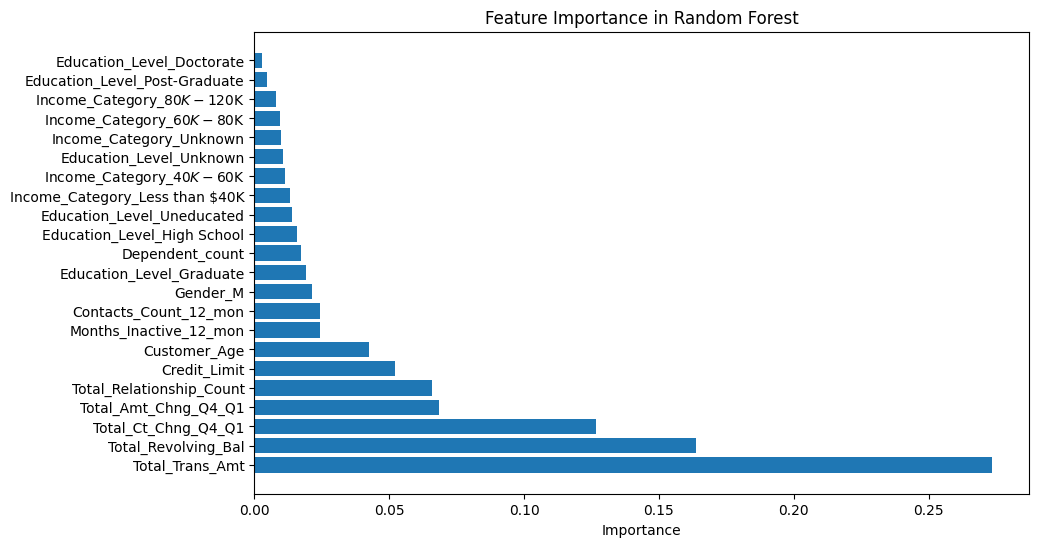

In [224]:
# Examine feature importances from the Random Forest model
feature_importances = rf_model2.feature_importances_

features = pd.DataFrame({
    'Feature': X_train2.columns,
    'Importance': feature_importances
})


features = features.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()


### **Modeling Phase 3 XGBoost** <br> **MODEL #1 XGBoost - 22 variables w/SMOTE**

In [228]:
# MODEL #1 XGBoost - 22 variables**
X_train_xg = df_train[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]

y_train_xg = df_train['Attrition_Flag']

X_test_xg = df_test[['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 
                'Education_Level_High School', 'Education_Level_Post-Graduate', 
                'Education_Level_Uneducated', 'Education_Level_Unknown',
                'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 
                'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 
                'Customer_Age', 'Credit_Limit', 
                'Total_Trans_Amt', 'Dependent_count', 'Total_Relationship_Count', 
                'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal']]

y_test_xg = df_test['Attrition_Flag']

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=50,
    eval_metric='logloss',
    scale_pos_weight = (len(y_train_xg[y_train_xg==0]) / len(y_train_xg[y_train_xg==1]))
)


xgb_model.fit(X_train_xg, y_train_xg)

# Predictions
y_pred_xg = xgb_model.predict(X_test_xg)

# Evaluation
print("Accuracy:", accuracy_score(y_test_xg, y_pred_xg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_xg, y_pred_xg))
print("\nClassification Report:\n", classification_report(y_test_xg, y_pred_xg))

Accuracy: 0.9708785784797631

Confusion Matrix:
 [[1661   40]
 [  19  306]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1701
           1       0.88      0.94      0.91       325

    accuracy                           0.97      2026
   macro avg       0.94      0.96      0.95      2026
weighted avg       0.97      0.97      0.97      2026



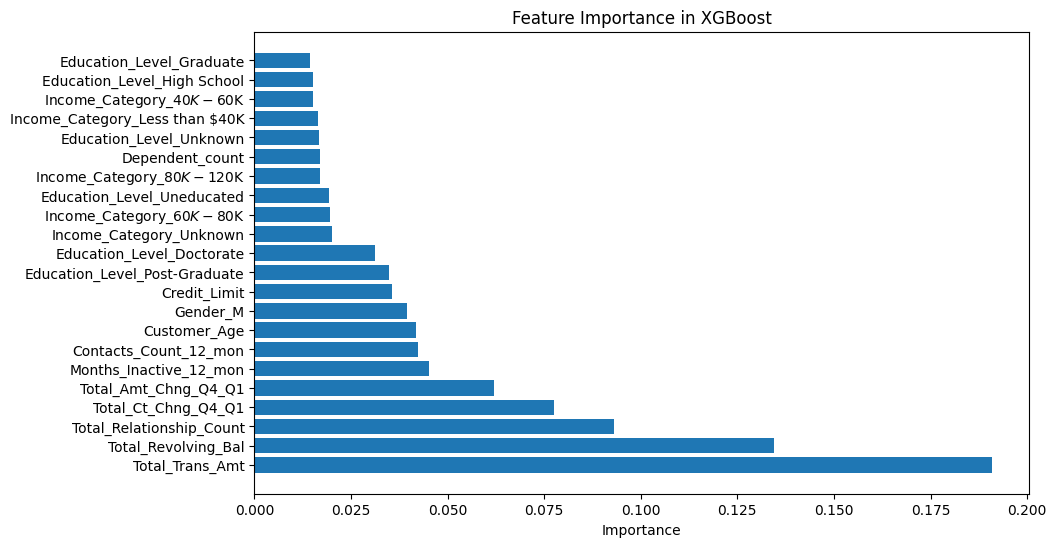

In [230]:
# Examine feature importances from the XGBoost model
feature_importances = xgb_model.feature_importances_

features = pd.DataFrame({
    'Feature': X_train_xg.columns,
    'Importance': feature_importances
})


features = features.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()


### **Examine the ROC Curve**

In [233]:
#plotting the Receiver Operating Characteristic Curve to distinguish between classes at different thresholds 

y_prob_log = logreg03.predict(X_test)  
y_prob_rf=rf_model2.predict_proba(X_test2)[:,1] 
y_prob_xg=xgb_model.predict_proba(X_test_xg)[:,1] 

In [235]:
y_prob_log #only outputting the attrited customer...

9760    0.182211
7413    0.671290
6074    0.723816
3520    0.804364
6103    0.517971
          ...   
1484    0.187486
1271    0.306552
4002    0.795607
8562    0.497869
413     0.581000
Length: 2026, dtype: float64

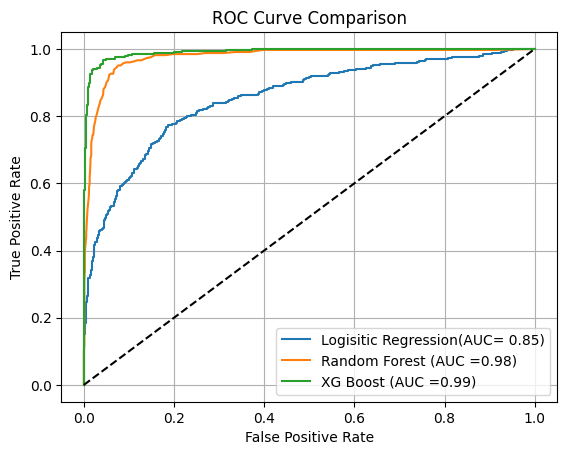

In [237]:
#ROC Curves 
fpr_log, tpr_log, thresholds = roc_curve(y_test,y_prob_log)
fpr_rf, tpr_rf, thresholds= roc_curve(y_test2,y_prob_rf)
fpr_xg, tpr_xg, thresholds= roc_curve(y_test_xg,y_prob_xg)

#Now will plot the ROC curve 
plt.plot(fpr_log, tpr_log, label = 'Logisitic Regression(AUC= {:.2f})'.format(roc_auc_score(y_test,y_prob_log)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC ={:.2f})'.format(roc_auc_score(y_test2,y_prob_rf)))
plt.plot(fpr_xg, tpr_xg, label='XG Boost (AUC ={:.2f})'.format(roc_auc_score(y_test_xg,y_prob_xg)))
plt.plot([0,1], [0,1], 'k--'); 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

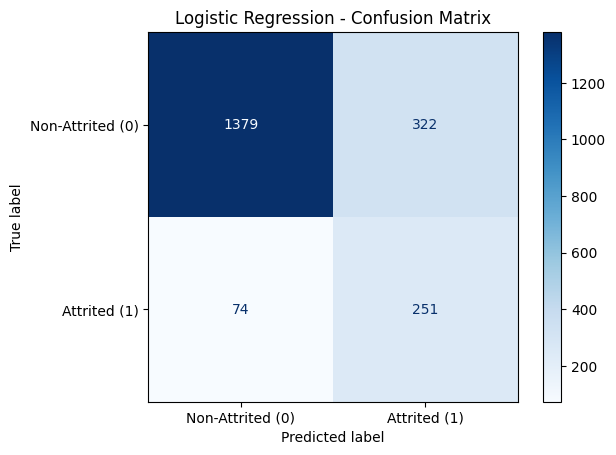

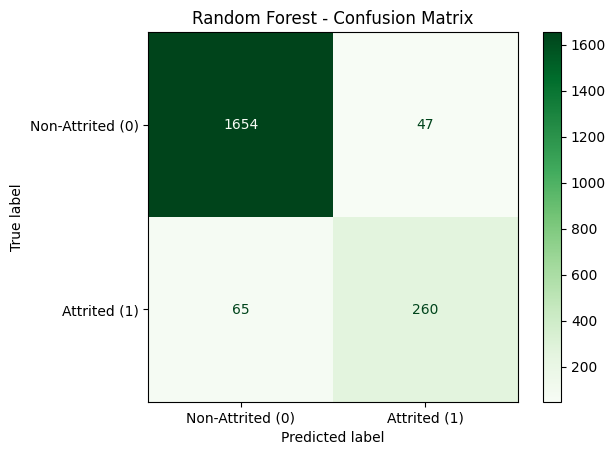

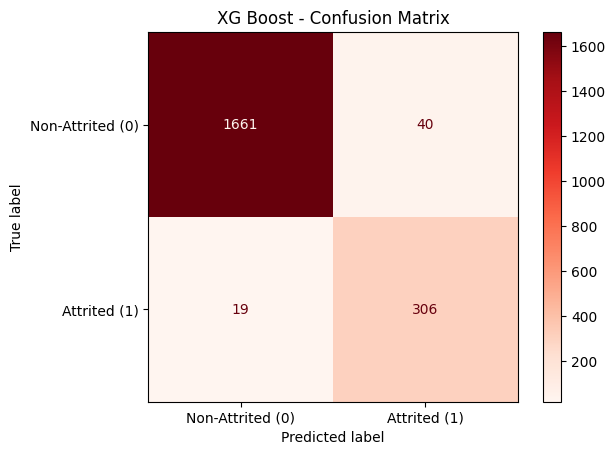

In [239]:
#Confusion Matrix Comparison 

# for logistic regression
cm_log = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Non-Attrited (0)', 'Attrited (1)'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

#for random forest model 
ConfusionMatrixDisplay.from_estimator(rf_model2, X_test2, y_test2, cmap='Greens', display_labels=['Non-Attrited (0)', 'Attrited (1)'])
plt.title("Random Forest - Confusion Matrix")
plt.show()

#for XG Boost
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_xg, y_test_xg, cmap='Reds', display_labels=['Non-Attrited (0)', 'Attrited (1)'])
plt.title("XG Boost - Confusion Matrix")
plt.show()

## **Discussion**
The initial logistic regression model, which included 22 features, demonstrated strong statistical significance but suffered from lower recall for the attrited customers,  which is a critical metric in churn prediction. To improve model simplicity and interpretability, a reduced logistic regression model was built using only statistically significant variables. While this model maintained reasonable performance, it still struggled to balance precision and recall for the minority class (attrited customers). <br>
To address this, a Random Forest model was introduced, leveraging SMOTE to balance the classes during training. The full-featured Random Forest significantly outperformed both logistic models in terms of accuracy, recall, and F1-score, achieving a recall of 0.80 for the attrited group and an overall accuracy of 94%. <br>
The XG Boost model performs slightly better than the Random Forest Model indicating there are highly complex patterns that are being captured better by the sequential nature of the model rather than the averaging that takes place in Random Forest.

**1. Which customer attributes are most strongly correlated with churn?** Customer spending attributes, specifically total transaction amount and total revolving balance are the most important features in predicting churn. <br>
**2. Which model best predicts customer churn?** XGBoost performs the best with the highest rates of recall and precision.<br>
**3. Which model best fits this specific business context?** While the logistic regression model offers a greater sense of interpretability, the manual processing time needed to reach a relatively acceptable rate of recall and precision is much greater than the tuning and processing time of the ensemble methods. While interpretability is important, the business context requires as low rate of false positives as possible. Therefor the XGBoost model is the best suited for this context.

